### Initial Imports and Configs

In [1]:
import json
import logging

import numpy as np

from pathlib import Path

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading the Meta Donor DataFrame

In [2]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

,brain_region,gene_id,gene_expression_values
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682..."
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154..."
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151..."


Converting the gene_expression_values from a stored string to a list

In [3]:
meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


### Calculating Mean Expression Value per Brain Region

In [4]:
br_H0 = calculate_br_mean_expression_values(meta_donor_df)
br_H0.head(3)

,brain_region,total_expression,total_sample_count,weighted_mean
0,4012,3.390829e+06,645601,5.252205
1,4013,5.877675e+06,1115129,5.270848
2,4014,5.498979e+06,1056438,5.205208


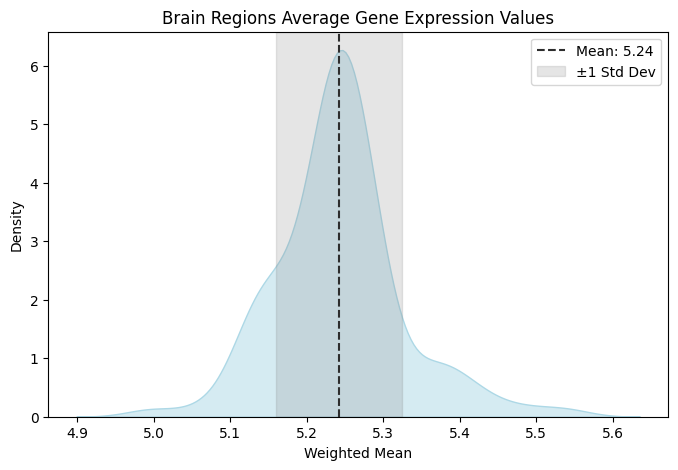

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute statistics
mean_val = br_H0["weighted_mean"].mean()
std_val = br_H0["weighted_mean"].std()  # Standard deviation
var_val = std_val**2  # Variance (not needed directly in plotting)

# Plot KDE
plt.figure(figsize=(8, 5))
sns.kdeplot(br_H0["weighted_mean"], fill=True, color="lightblue", alpha=0.5)

# Add mean line
plt.axvline(mean_val, color=mean_color, linestyle="--", label=f"Mean: {mean_val:.2f}")

# Shade variance region (±1 standard deviation)
plt.axvspan(mean_val - std_val, mean_val + std_val, color="gray", alpha=0.2, label="±1 Std Dev")

# Labels & legend
plt.xlabel("Weighted Mean")
plt.ylabel("Density")
plt.title("Brain Regions Average Gene Expression Values")
plt.legend()

plt.savefig(PLOTS_PTH / Path('KDE_Brain_Regions.png'))
plt.show()


Test on Weighted Means

In [17]:
# Test on weighted mean
X = br_H0["weighted_mean"].to_numpy().reshape(-1,1)

### Kolmogorov-Smirnov (KS) Test AND Shapiro-Wilk Test for Normality

In [18]:
from scipy.stats import shapiro, kstest

shapiro_stat, shapiro_p = shapiro(X)
logger.info(f"Shapiro-Wilk Test: Statistic = {shapiro_stat}, p-value = {shapiro_p}")

ks_stat, ks_p = kstest(X, "norm", args=(np.mean(X), np.std(X)))
logger.info(f"KS Test: Statistic = {ks_stat}, p-value = {ks_p}")

Shapiro-Wilk Test: Statistic = 0.9465224742889404, p-value = 0.000397304305806756
KS Test: Statistic = 0.9998446149556697, p-value = 0.0


### Hopkins test to know if data is Clustered

In [19]:
from sklearn.neighbors import NearestNeighbors
import random

def hopkins_statistic(X, n_samples=50):
    d = X.shape[1]
    n = len(X)
    if n_samples > n:
        n_samples = n
    
    # Random sample from the dataset
    sample_indices = random.sample(range(n), n_samples)
    sample_points = X[sample_indices]

    # Generate uniformly random points in the same range
    min_vals, max_vals = X.min(axis=0), X.max(axis=0)
    random_points = np.random.uniform(min_vals, max_vals, size=(n_samples, d))

    # Nearest neighbor distance in original data
    nn = NearestNeighbors(n_neighbors=2).fit(X)
    u_distances = nn.kneighbors(random_points, n_neighbors=1)[0].sum()

    # Nearest neighbor distance in random data
    w_distances = nn.kneighbors(sample_points, n_neighbors=2)[0][:, 1].sum()

    H = u_distances / (u_distances + w_distances)
    return H

# Compute Hopkins statistic
H = hopkins_statistic(X)
logger.info(f"Hopkins Statistic: {H}")

# Interpretation
if H < 0.5:
    logger.info("Data is likely uniformly distributed (no clusters).")
else:
    logger.info("Data is likely clustered.")


Hopkins Statistic: 0.6664751519011978
Data is likely clustered.


### Gaussian Mixture Model with BIC to decide the number of clusters

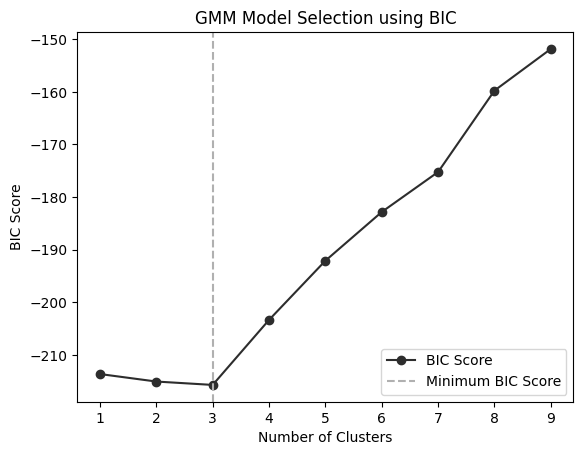

Optimal number of clusters: 3


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Fit GMM for different cluster numbers and compute BIC
bic_scores = []
n_components_range = range(1, 10)
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    
# Plot BIC scores
plt.plot(n_components_range, bic_scores, marker='o', color=mean_color, label="BIC Score")

# Add threshold line at component number 3
plt.axvline(3, color=variance_color, linestyle='dashed', linewidth=1.5, label="Minimum BIC Score")

plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score")
plt.title("GMM Model Selection using BIC")
plt.legend()

plt.savefig(PLOTS_PTH / Path(f'GMM_BIC_Number_of_Clusters.png'))

plt.show()

# Choose the optimal number of clusters
optimal_n = n_components_range[np.argmin(bic_scores)]
logger.info(f"Optimal number of clusters: {optimal_n}")


### Clustering Based on the Recommended number of Clusters

In [21]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['weighted_mean']

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(br_H0[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
br_H0['cluster'] = kmeans.fit_predict(df_scaled)

# View the clustered dataframe
logger.info(br_H0.head())

   brain_region  total_expression  total_sample_count  weighted_mean  cluster
0          4012      3.390829e+06              645601       5.252205        0
1          4013      5.877675e+06             1115129       5.270848        0
2          4014      5.498979e+06             1056438       5.205208        0
3          4023      1.326210e+07             2523713       5.254994        0
4          4024      1.225865e+07             2347640       5.221691        0


Visualising Clusters in TSNE

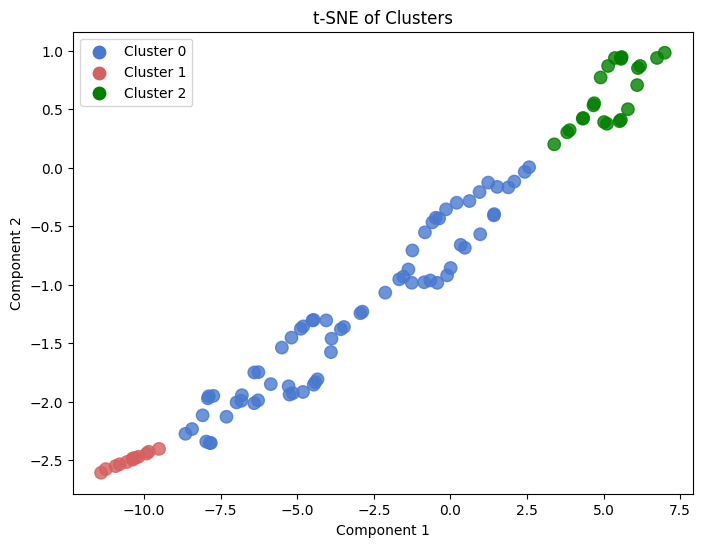

In [22]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(br_H0[['weighted_mean']])

# Assign colors based on cluster
colors = [cluster_colors[c] for c in br_H0['cluster']]

# Plot clusters with custom colors
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=colors, alpha=0.8, s=80)

# Add legend for clusters
for cluster, color in cluster_colors.items():
    plt.scatter([], [], c=[color], label=f'Cluster {cluster}', s=80)

plt.legend()
plt.title('t-SNE of Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.savefig(PLOTS_PTH / Path(f'TSNE Brain Region Clusters.png'))

plt.show()


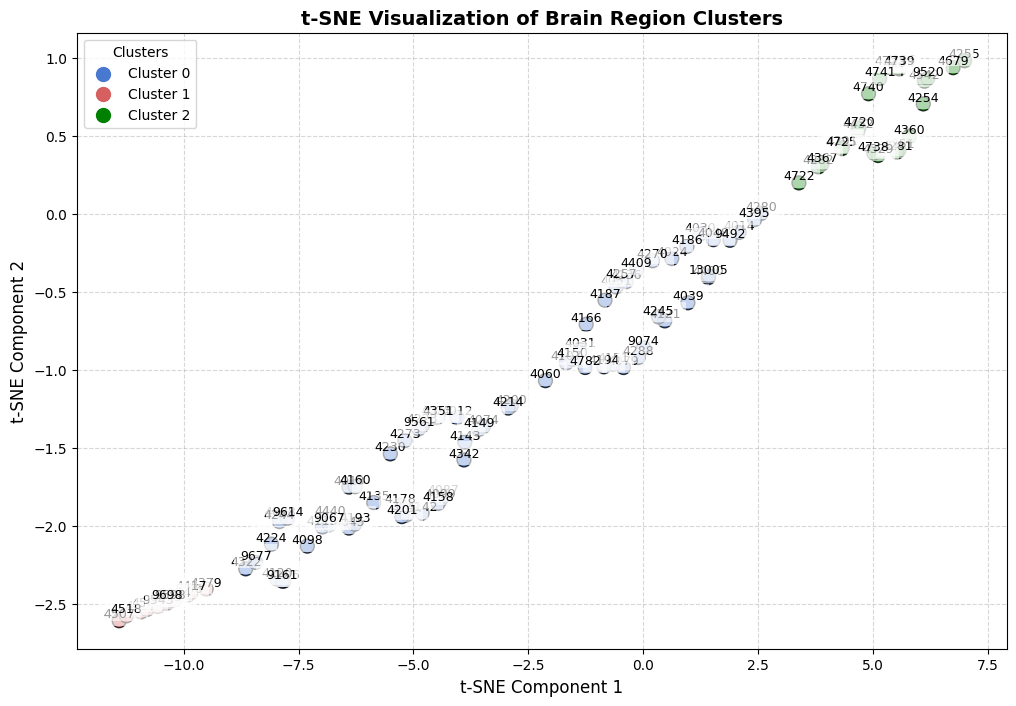

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(br_H0[['weighted_mean']])

# Assign colors based on cluster
colors = [cluster_colors[c] for c in br_H0['cluster']]

# Create figure with larger size
plt.figure(figsize=(12, 8))

# Plot clusters with custom colors
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=colors, alpha=0.8, s=100, edgecolors="k")

# Add brain region labels at each point
for i, txt in enumerate(br_H0['brain_region']):
    plt.text(df_tsne[i, 0], df_tsne[i, 1], str(txt), fontsize=9, ha='center', va='bottom',
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Add legend for clusters
for cluster, color in cluster_colors.items():
    plt.scatter([], [], c=[color], label=f'Cluster {cluster}', s=100)

plt.legend(title="Clusters", fontsize=10)
plt.title('t-SNE Visualization of Brain Region Clusters', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


### Write Clusters into Files 

In [24]:
meta_donor_cluster_0 = br_H0[br_H0['cluster'] == 0]
meta_donor_cluster_1 = br_H0[br_H0['cluster'] == 1]
meta_donor_cluster_2 = br_H0[br_H0['cluster'] == 2]
# Create an empty dictionary to store DataFrames
cluster_dfs = {}

# Loop through each unique cluster
for cluster in br_H0['cluster'].unique():
    # Get brain regions that belong to this cluster
    brain_regions_in_cluster = br_H0[br_H0['cluster'] == cluster]['brain_region'].tolist()
    
    # Filter df_samples to include only those brain regions
    cluster_dfs[cluster] = meta_donor_df[meta_donor_df['brain_region'].isin(brain_regions_in_cluster)]

# Now you have separate DataFrames stored in cluster_dfs dictionary
df_cluster_0 = cluster_dfs[0]  # DataFrame for cluster 0
df_cluster_1 = cluster_dfs[1]  # DataFrame for cluster 1
df_cluster_2 = cluster_dfs[2]  # DataFrame for cluster 2

logger.info(f"Number of Brain Regions in Cluster 0 Samples DF == Clusters 0 Df: {len(df_cluster_0['brain_region'].unique()) == len(meta_donor_cluster_0)}")
logger.info(f"Number of Brain Regions in Cluster 1 Samples DF == Clusters 1 Df: {len(df_cluster_1['brain_region'].unique()) == len(meta_donor_cluster_1)}")
logger.info(f"Number of Brain Regions in Cluster 2 Samples DF == Clusters 2 Df: {len(df_cluster_2['brain_region'].unique()) == len(meta_donor_cluster_2)}")

write_df_to_csv(df_cluster_0, PROCESSED_DONORS_GE_PATH / Path(f"cluster_0.csv"))
write_df_to_csv(df_cluster_1, PROCESSED_DONORS_GE_PATH / Path(f"cluster_1.csv"))
write_df_to_csv(df_cluster_2, PROCESSED_DONORS_GE_PATH / Path(f"cluster_2.csv"))

Number of Brain Regions in Cluster 0 Samples DF == Clusters 0 Df: True
Number of Brain Regions in Cluster 1 Samples DF == Clusters 1 Df: True
Number of Brain Regions in Cluster 2 Samples DF == Clusters 2 Df: True


Brain Regions with the most sample count in each cluster

In [25]:
# Find the index of the row with the highest 'total_sample_count' in each cluster
idx = br_H0.groupby('cluster')['total_sample_count'].idxmax()

# Retrieve the rows using the indices
result = br_H0.loc[idx]

# Get Brain Regions in a list
top_brain_regions = result["brain_region"].to_list()

logger.info(result)
logger.info(top_brain_regions)

    brain_region  total_expression  total_sample_count  weighted_mean  cluster
58          4288      1.473087e+07             2817168       5.228964        0
71          4417      6.281332e+06             1173820       5.351188        1
47          4251      7.538313e+06             1467275       5.137628        2
[4288, 4417, 4251]


Selecting only Samples from that brain region

In [26]:
brain_region_cluster_0 = meta_donor_df.loc[meta_donor_df["brain_region"] == top_brain_regions[0]]
logger.info(len(brain_region_cluster_0))

brain_region_cluster_1 = meta_donor_df.loc[meta_donor_df["brain_region"] == top_brain_regions[1]]
logger.info(len(brain_region_cluster_1))


brain_region_cluster_2 = meta_donor_df.loc[meta_donor_df["brain_region"] == top_brain_regions[2]]
logger.info(len(brain_region_cluster_2))

logger.info(brain_region_cluster_2.head(3))

write_df_to_csv(brain_region_cluster_0, PROCESSED_DONORS_GE_PATH / Path(f"0_{top_brain_regions[0]}.csv"))
write_df_to_csv(brain_region_cluster_1, PROCESSED_DONORS_GE_PATH / Path(f"1_{top_brain_regions[1]}.csv"))
write_df_to_csv(brain_region_cluster_2, PROCESSED_DONORS_GE_PATH / Path(f"2_{top_brain_regions[2]}.csv"))


29179
29179
29179
         brain_region  gene_id  \
1371413          4251        2   
1371414          4251        3   
1371415          4251        6   

                                    gene_expression_values  sample_count  \
1371413  [1.88109852410538, 7.79403937562961, 1.6383945...            50   
1371414  [6.29689846089316, 9.01629413652164, 9.5737847...           100   
1371415  [1.62612311971316, 2.02427350756536, 6.5224755...           175   

         sum_expression  
1371413      233.602860  
1371414      808.582310  
1371415      520.906506  
